# 1. Setup and data load

## 1.1 Libraries

In [1]:
import pickle
import joblib
import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    brier_score_loss,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set()
np.random.seed(42)


## 1.2 Load preprocessed data

In [2]:
# BASELINE features
with open("./outputs/processed/baseline_preprocessed.pkl", "rb") as f:
    baseline_data = pickle.load(f)

X_train_basic = baseline_data["X_train"]
X_val_basic   = baseline_data["X_val"]
X_test_basic  = baseline_data["X_test"]
y_train_basic = baseline_data["y_train"]
y_val_basic   = baseline_data["y_val"]
y_test_basic  = baseline_data["y_test"]

# EXTENDED features
with open("./outputs/processed/extended_preprocessed.pkl", "rb") as f:
    extended_data = pickle.load(f)

X_train_ext = extended_data["X_train"]
X_val_ext   = extended_data["X_val"]
X_test_ext  = extended_data["X_test"]
y_train_ext = extended_data["y_train"]
y_val_ext   = extended_data["y_val"]
y_test_ext  = extended_data["y_test"]


## 1.3 Load trained models

In [3]:
# Random Forest: baseline & extended
rf_baseline_res = joblib.load("./outputs/models/baseline_rf_results.pkl")
rf_extended_res = joblib.load("./outputs/models/extended_rf_results.pkl")

rf_baseline_best = rf_baseline_res["best_model"]
rf_extended_best = rf_extended_res["best_model"]

# XGBoost: baseline & extended
xgb_baseline_res = joblib.load("./outputs/models/xgboost_baseline_results.pkl")
xgb_extended_res = joblib.load("./outputs/models/xgboost_extended_results.pkl")

xgb_baseline_best = xgb_baseline_res["best_model"]
xgb_extended_best = xgb_extended_res["best_model"]


c:\Users\Office\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.4 clean data

In [4]:
# Fix naming mismatch between random forest and xgboost
rename_map = {
    "Avg<2.5": "Avgless_than_2.5",
    "Avg>2.5": "Avggreater_than_2.5",
    "Max<2.5": "Maxless_than_2.5",
    "Max>2.5": "Maxgreater_than_2.5",
    "Min<2.5": "Minless_than_2.5",
    "Min>2.5": "Mingreater_than_2.5",

    "AvgC<2.5": "AvgCless_than_2.5",
    "AvgC>2.5": "AvgCgreater_than_2.5",
    "MaxC<2.5": "MaxCless_than_2.5",
    "MaxC>2.5": "MaxCgreater_than_2.5",
    "MinC<2.5": "MinCless_than_2.5",
    "MinC>2.5": "MinCgreater_than_2.5",

    "Disagreement<2.5": "Disagreementless_than_2.5",
    "Disagreement>2.5": "Disagreementgreater_than_2.5",
    "DisagreementC<2.5": "DisagreementCless_than_2.5",
    "DisagreementC>2.5": "DisagreementCgreater_than_2.5",
}

# 2 Overall model comparison

In [ ]:
models = [
    ("RF Baseline",  "rf",  rf_baseline_best,  X_test_basic, y_test_basic),
    ("XGB Baseline", "xgb", xgb_baseline_best, X_test_basic, y_test_basic),
    ("RF Extended",  "rf",  rf_extended_best,  X_test_ext,   y_test_ext),
    ("XGB Extended", "xgb", xgb_extended_best, X_test_ext,   y_test_ext),
]

rows = []

for name, kind, model, X_test, y_test in models:
    # For XGBoost: use a renamed COPY
    if kind == "xgb":
        # safe if X_test is a DataFrame
        X_eval = X_test.rename(columns=rename_map)
    else:
        # Random Forest must see the original column names
        X_eval = X_test

    proba = model.predict_proba(X_eval)[:, 1]
    y_pred = (proba >= 0.5).astype(int)

    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, proba),
        "LogLoss": log_loss(y_test, proba),
    })

metrics_df = pd.DataFrame(rows)
metrics_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,LogLoss,Brier
0,RF Baseline,0.549586,0.562365,0.502767,0.530898,0.566902,0.685520,0.246235
1,XGB Baseline,0.548604,0.554666,0.555894,0.555279,0.564373,0.686582,0.246757
2,RF Extended,0.577080,0.592296,0.531821,0.560432,0.603718,0.675538,0.241371
3,XGB Extended,0.569645,0.566814,0.640841,0.601558,0.603210,0.676553,0.241844


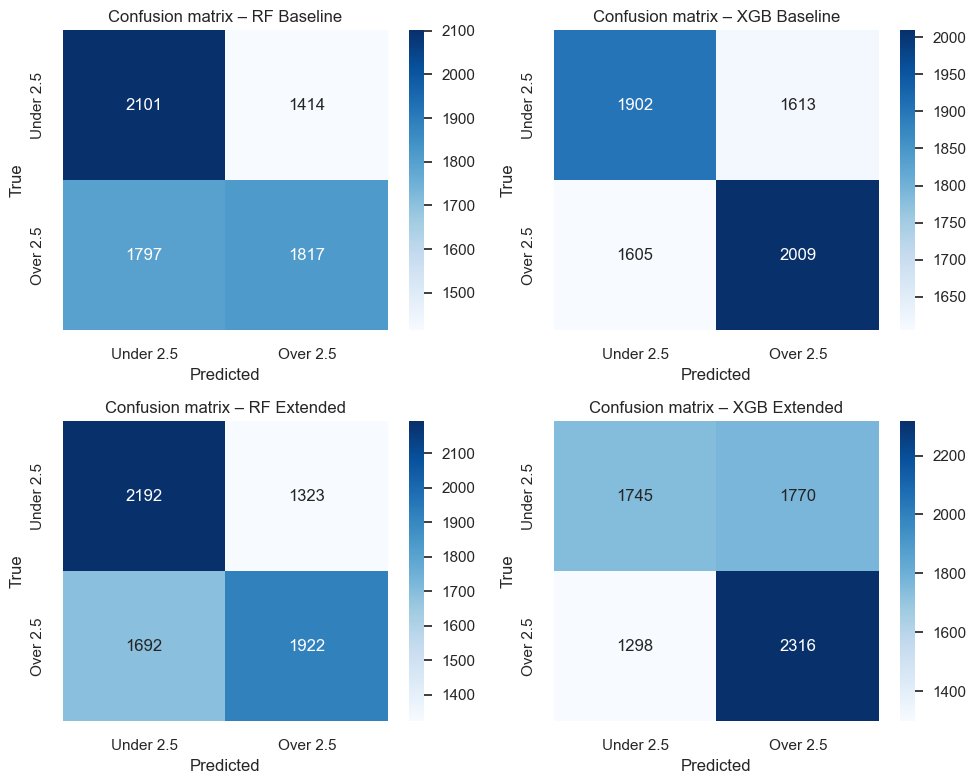

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 2x2 grid for 4 models
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for (name, kind, model, X_test, y_test), ax in zip(models, axes.flatten()):
    # XGBoost: use renamed copy of columns
    if kind == "xgb":
        X_eval = X_test.rename(columns=rename_map)
    else:
        X_eval = X_test

    y_pred = model.predict(X_eval)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Under 2.5", "Over 2.5"],
        yticklabels=["Under 2.5", "Over 2.5"],
        ax=ax
    )
    ax.set_title(f"Confusion matrix – {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


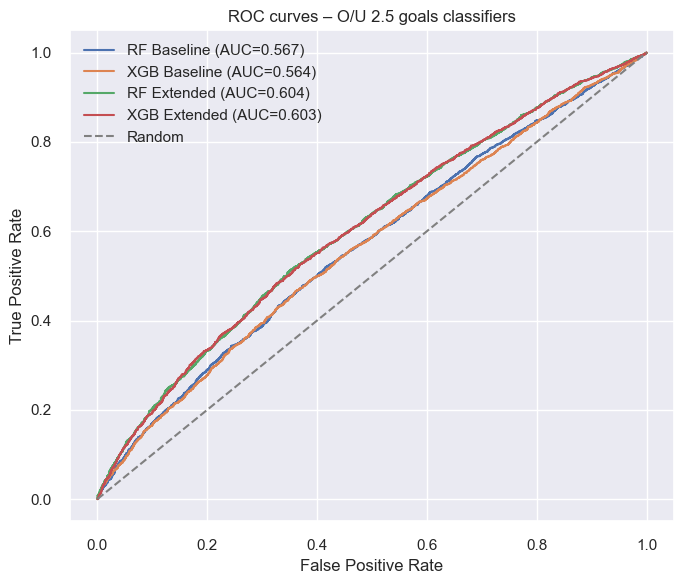

In [45]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(7, 6))

for name, kind, model, X_test, y_test in models:
    if kind == "xgb":
        X_eval = X_test.rename(columns=rename_map)
    else:
        X_eval = X_test

    proba = model.predict_proba(X_eval)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves – O/U 2.5 goals classifiers")
plt.legend()
plt.tight_layout()
plt.show()


# 3 Model comparison by countries

In [46]:
# Find the dummy columns for leagues (Div_*)
div_cols = [c for c in X_test_basic.columns if c.startswith("Div_")]

# For each row, pick the Div_* column with the highest value (=1)
test_leagues = X_test_basic[div_cols].idxmax(axis=1)

# remove 'Div_' prefix
test_leagues = test_leagues.str.replace("^Div_", "", regex=True)

test_leagues.head()


0    B1
1    B1
2    B1
3    B1
4    B1
dtype: object

In [130]:
metrics_country_rows = []
unique_leagues = sorted(test_leagues.unique())

for league in unique_leagues:
    mask = (test_leagues == league)

    for name, kind, model, X_test, y_test in models:
        # Subset test set to this league
        X_sub = X_test[mask]
        y_sub = y_test[mask]

        # XGBoost needs renamed columns (copy, no inplace)
        if kind == "xgb":
            X_eval = X_sub.rename(columns=rename_map)
        else:
            X_eval = X_sub

        # Predict probabilities and class labels
        proba = model.predict_proba(X_eval)[:, 1]
        y_pred = (proba >= 0.5).astype(int)

        metrics_country_rows.append({
            "League": league,
            "Model": name,
            "n_matches": mask.sum(),
            "Accuracy": accuracy_score(y_sub, y_pred),
            "Precision": precision_score(y_sub, y_pred, zero_division=0),
            "Recall": recall_score(y_sub, y_pred, zero_division=0),
            "F1": f1_score(y_sub, y_pred, zero_division=0),
            "ROC_AUC": roc_auc_score(y_sub, proba),
            "LogLoss": log_loss(y_sub, proba)
        })

metrics_country_df = pd.DataFrame(metrics_country_rows)
metrics_country_df


,League,Model,n_matches,Accuracy,Precision,Recall,F1,ROC_AUC,LogLoss
0,B1,RF Baseline,312,0.538462,0.531034,0.950617,0.681416,0.544198,0.692348
1,B1,XGB Baseline,312,0.544872,0.533557,0.981481,0.691304,0.567798,0.693035
2,B1,RF Extended,312,0.599359,0.580087,0.827160,0.681934,0.655926,0.666126
3,B1,XGB Extended,312,0.586538,0.561798,0.925926,0.699301,0.642634,0.672607
4,D1,RF Baseline,306,0.594771,0.596721,0.994536,0.745902,0.632636,0.656821
...,...,...,...,...,...,...,...,...,...
79,SP2,XGB Extended,462,0.588745,0.663366,0.300448,0.413580,0.598045,0.681727
80,T1,RF Baseline,342,0.552632,0.559603,0.894180,0.688391,0.586230,0.678466
81,T1,XGB Baseline,342,0.540936,0.553691,0.873016,0.677618,0.569890,0.679276
82,T1,RF Extended,342,0.596491,0.616438,0.714286,0.661765,0.646333,0.651544


In [127]:
import re

# 1) Create a "country-level" / merged-league column by removing digits from League
metrics_country_df["Country"] = (
    metrics_country_df["League"]
    .str.replace(r"\d+", "", regex=True)  # drop all digits
    .str.strip()                          # remove extra spaces if any
)

# 2) Aggregate metrics by this merged league + model
metric_cols = ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "LogLoss"]

metrics_country_agg = (
    metrics_country_df
    .groupby(["Country", "Model"], as_index=False)
    .agg(
        n_matches=("n_matches", "sum"),
        **{m: (m, "mean") for m in metric_cols}
    )
)

metrics_country_agg.head()

,Country,Model,n_matches,Accuracy,Precision,Recall,F1,ROC_AUC,LogLoss
0,B,RF Baseline,312,0.538462,0.531034,0.950617,0.681416,0.544198,0.692348
1,B,RF Extended,312,0.599359,0.580087,0.827160,0.681934,0.655926,0.666126
2,B,XGB Baseline,312,0.544872,0.533557,0.981481,0.691304,0.567798,0.693035
3,B,XGB Extended,312,0.586538,0.561798,0.925926,0.699301,0.642634,0.672607
4,D,RF Baseline,612,0.594771,0.605900,0.923092,0.730094,0.594965,0.665280


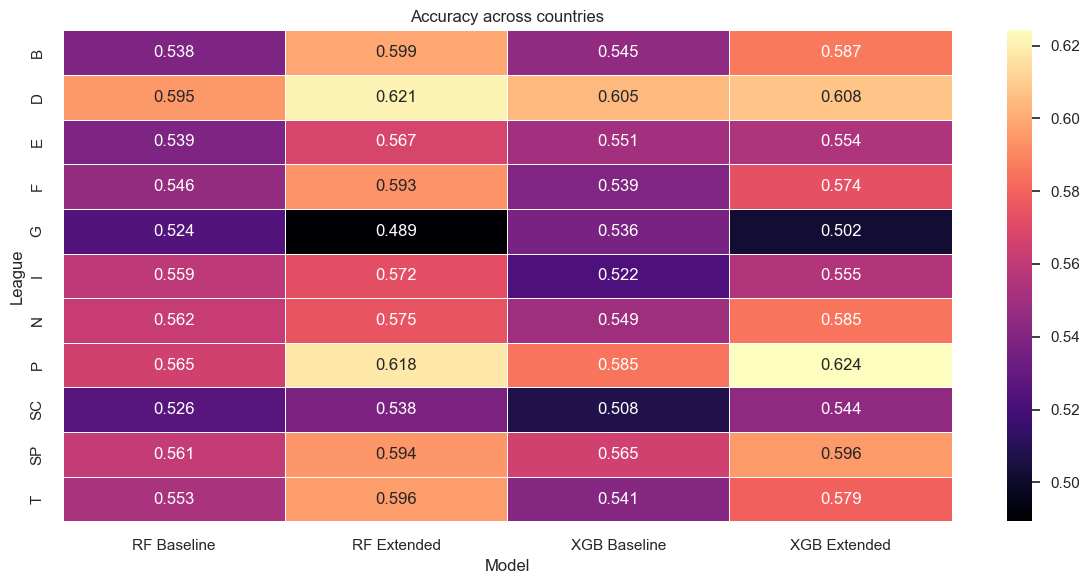

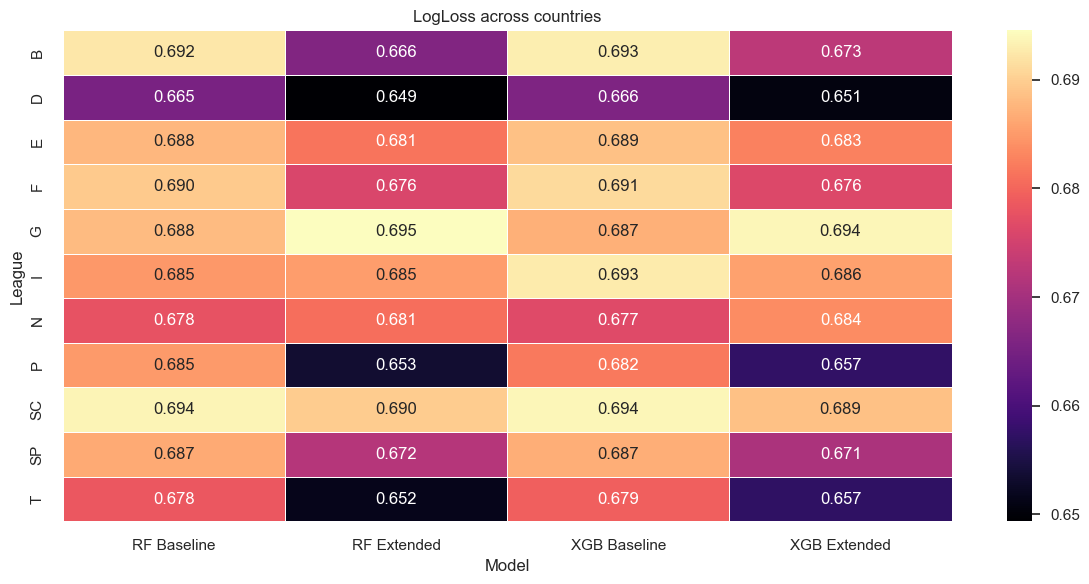

In [128]:
# Accuracy heatmap by country
metrics_country_acc = (
    metrics_country_agg
    .pivot(index="Country", columns="Model", values="Accuracy" )
    .sort_index()
)


plt.figure(figsize=(12, 6))
sns.heatmap(
    metrics_country_acc,
    annot=True,
    fmt=".3f",
    cmap="magma",
    linewidths=0.5,
    linecolor="white"
)

plt.title("Accuracy across countries")
plt.xlabel("Model")
plt.ylabel("League")
plt.tight_layout()
plt.show()


# LogLoss heatmap by country
metrics_country_ll = (
    metrics_country_agg
    .pivot(index="Country", columns="Model", values="LogLoss" )
    .sort_index()
)


plt.figure(figsize=(12, 6))
sns.heatmap(
    metrics_country_ll,
    annot=True,
    fmt=".3f",
    cmap="magma",
    linewidths=0.5,
    linecolor="white"
)

plt.title("LogLoss across countries")
plt.xlabel("Model")
plt.ylabel("League")
plt.tight_layout()
plt.show()


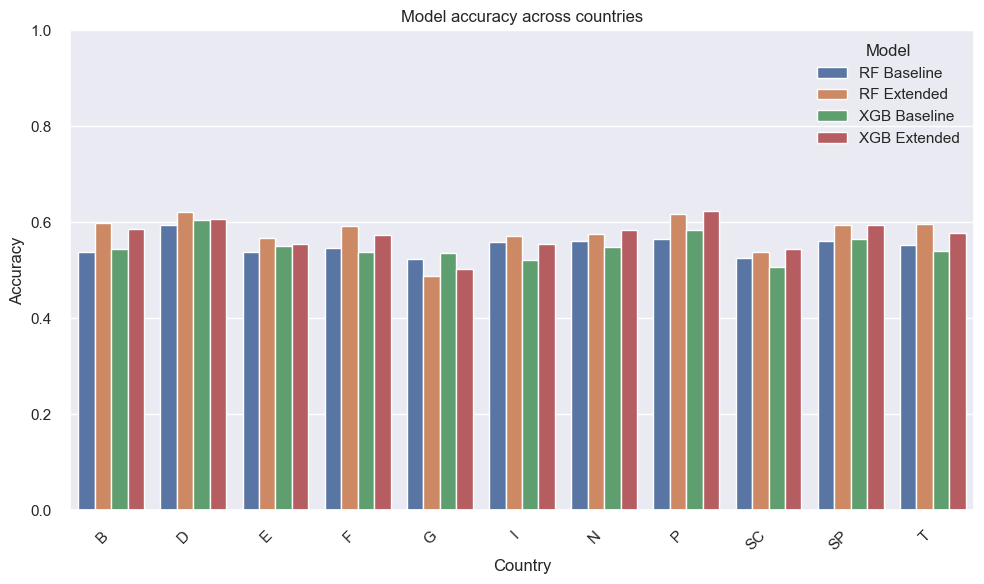

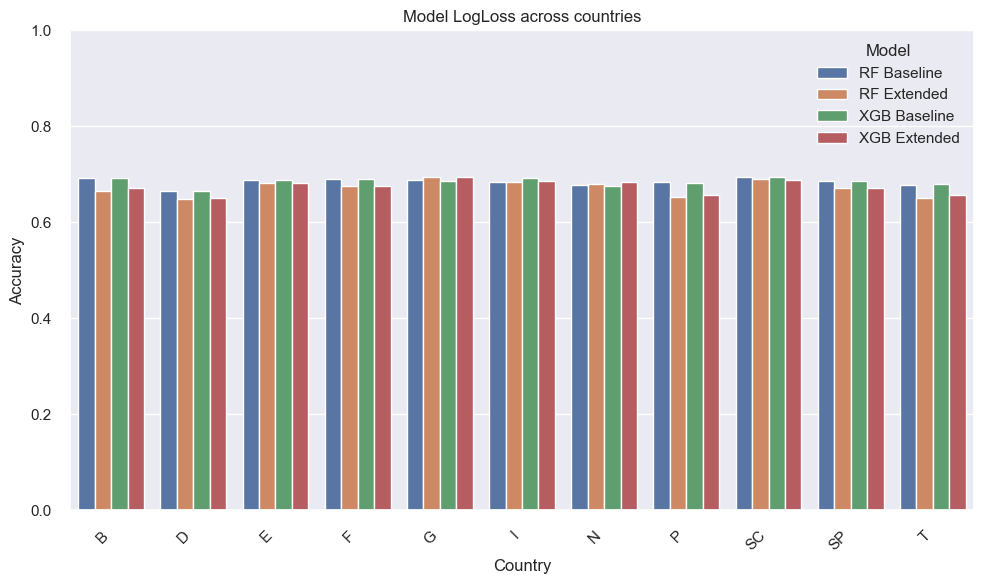

In [125]:
# Accuraccy across countries
plt.figure(figsize=(10, 6))
sns.barplot(
    data=metrics_country_agg,
    x="Country",
    y="Accuracy",
    hue="Model"
)
plt.title("Model accuracy across countries")
plt.xlabel("Country")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.ylim(0, 1)
plt.show()


# LogLoss across countries
plt.figure(figsize=(10, 6))
sns.barplot(
    data=metrics_country_agg,
    x="Country",
    y="LogLoss",
    hue="Model"
)
plt.title("Model LogLoss across countries")
plt.xlabel("Country")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 4 Optimal profit margin

## 4.1 Setup

In [50]:
# Parameters
m_operations = 0.03
k = 0.3
alpha = 1000
epsilon = 3
b = 12

# Accuracies
A0 = 0.55 # placeholder for baseline model accuracy
A1 = 0.56 # placeholder for extended model accuracy

# Functions
risk_margin = lambda A: k * (1 - A)
total_margin = lambda m_profit, A: m_profit + m_operations + risk_margin(A)
volume = lambda m: alpha * m**(-epsilon)
profit = lambda m_profit, A: volume(total_margin(m_profit, A)) * m_profit * b

## 4.2 Analytical Solution

**Given:**
- $\Pi(m_{\text{profit}}) = V(m) \cdot m_{\text{profit}} \cdot b$
- $V(m) = \alpha \cdot m^{-\varepsilon}$
- $m = m_{\text{profit}} + m_{\text{operations}} + k(1-A)$

**Substituting:**

$$\Pi(m_{\text{profit}}) = \alpha \cdot (m_{\text{profit}} + m_{\text{operations}} + k(1-A))^{-\varepsilon} \cdot m_{\text{profit}} \cdot b$$

**To maximize, we take derivative and set to zero:**

$$\frac{d\Pi}{dm_{\text{profit}}} = 0$$

**Using product rule:**

$$\frac{d\Pi}{dm_{\text{profit}}} = \alpha \cdot b \cdot m^{-\varepsilon} + m_{\text{profit}} \cdot \alpha \cdot b \cdot (-\varepsilon) \cdot m^{-\varepsilon-1}$$

$$= \alpha \cdot b \cdot m^{-\varepsilon-1} \cdot [m - \varepsilon \cdot m_{\text{profit}}]$$

**Setting equal to zero:**

$$m - \varepsilon \cdot m_{\text{profit}} = 0$$

$$m = \varepsilon \cdot m_{\text{profit}}$$

**Therefore:**

$$m_{\text{profit}} + m_{\text{operations}} + k(1-A) = \varepsilon \cdot m_{\text{profit}}$$

$$m_{\text{profit}}(\varepsilon - 1) = m_{\text{operations}} + k(1-A)$$

$$\boxed{m_{\text{profit}}^* = \frac{m_{\text{operations}} + k(1-A)}{\varepsilon - 1}}$$

In [51]:
# Calculate analytical solution
def analytical_optimal_profit_margin(A):
    return (m_operations + k*(1-A)) / (epsilon - 1)

m_profit_analytical = analytical_optimal_profit_margin(A1)
print(f"Analytical solution for A1 = {A1}:")
print(f"  m_profit* = [{m_operations} + {k}(1-{A1})] / ({epsilon} - 1)")
print(f"  m_profit* = {m_profit_analytical:.4f}")

Analytical solution for A1 = 0.56:
  m_profit* = [0.03 + 0.3(1-0.56)] / (3 - 1)
  m_profit* = 0.0810


## 4.3 Numerical verification

In [52]:
# Current state
m0_total = 0.3
m_profit_0 = m0_total - m_operations - risk_margin(A0)

# Find optimal profit margin for A1 numerically
result = minimize_scalar(lambda m: -profit(m, A1), bounds=(0.01, 0.5), method='bounded')
m_profit_numerical = result.x
profit_A0 = profit(m_profit_0, A0)
profit_A1_optimal = -result.fun

print(f"Numerical solution (minimize_scalar): {m_profit_numerical:.5f}")
print(f"Analytical solution: {m_profit_analytical:.5f}")
print(f"Difference: {abs(m_profit_numerical - m_profit_analytical):.6f}")

Numerical solution (minimize_scalar): 0.08100
Analytical solution: 0.08100
Difference: 0.000002


## 4.4 Results

In [53]:
# Results using analytical solution
profit_A1_analytical = profit(m_profit_analytical, A1)
delta_profit = profit_A1_analytical - profit_A0

print(f"Current profit (A0={A0}): ${profit_A0:.2f}")
print(f"Optimal profit margin for A1={A1}: {m_profit_analytical:.4f}")
print(f"Optimal profit (A1): ${profit_A1_analytical:.2f}")
print(f"\nProfit improvement = maximum price for extended data: ${delta_profit:.2f}")

Current profit (A0=0.55): $60000.00
Optimal profit margin for A1=0.56: 0.0810
Optimal profit (A1): $67740.35

Profit improvement = maximum price for extended data: $7740.35
